In [6]:
import xarray
data = xarray.open_dataset("/homes/starrgw1/code/gnss-tid/outputs/2024-11-22/10-51-29/autofocus.h5")

In [11]:
data

<xarray.Dataset> Size: 1GB
Dimensions:     (x: 453, y: 290, time: 239, py: 8, px: 13, ky: 64, kx: 64)
Coordinates:
  * x           (x) float64 4kB -2.194e+03 -2.184e+03 ... 2.311e+03 2.321e+03
  * y           (y) float64 2kB -1.284e+03 -1.274e+03 ... 1.591e+03 1.601e+03
  * time        (time) datetime64[ns] 2kB 2015-03-25T22:00:00 ... 2015-03-26T...
  * kx          (kx) float64 512B 0.0 0.001563 0.003125 ... -0.003125 -0.001563
  * ky          (ky) float64 512B 0.0 0.001563 0.003125 ... -0.003125 -0.001563
  * px          (px) float64 104B -1.874e+03 -1.555e+03 ... 1.641e+03 1.961e+03
  * py          (py) float64 64B -964.3 -644.9 -325.5 ... 632.8 952.2 1.272e+03
Data variables:
    image       (time, y, x) float64 251MB ...
    patch       (time, py, px, ky, kx) float64 814MB ...
    Fx          (time, py, px) float64 199kB ...
    Fy          (time, py, px) float64 199kB ...
    F           (time, py, px) float64 199kB ...
    height      (time) float64 2kB ...
    n           (time) float64 2kB ...
    objective   (time) float64 2kB ...
    cx          (time) float64 2kB ...
    cy          (time) float64 2kB ...
    wavelength  (time) float64 2kB ...
    offset      (time) float64 2kB ...
Attributes:
    coord_center:  [ 36.  -97.5]

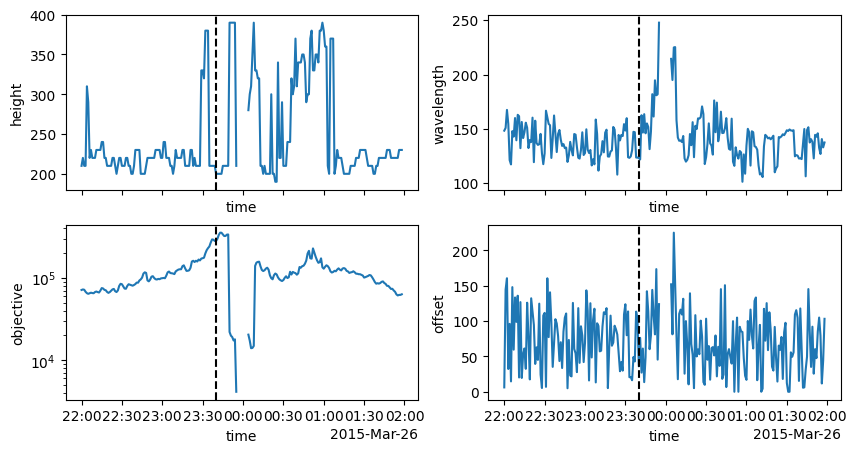

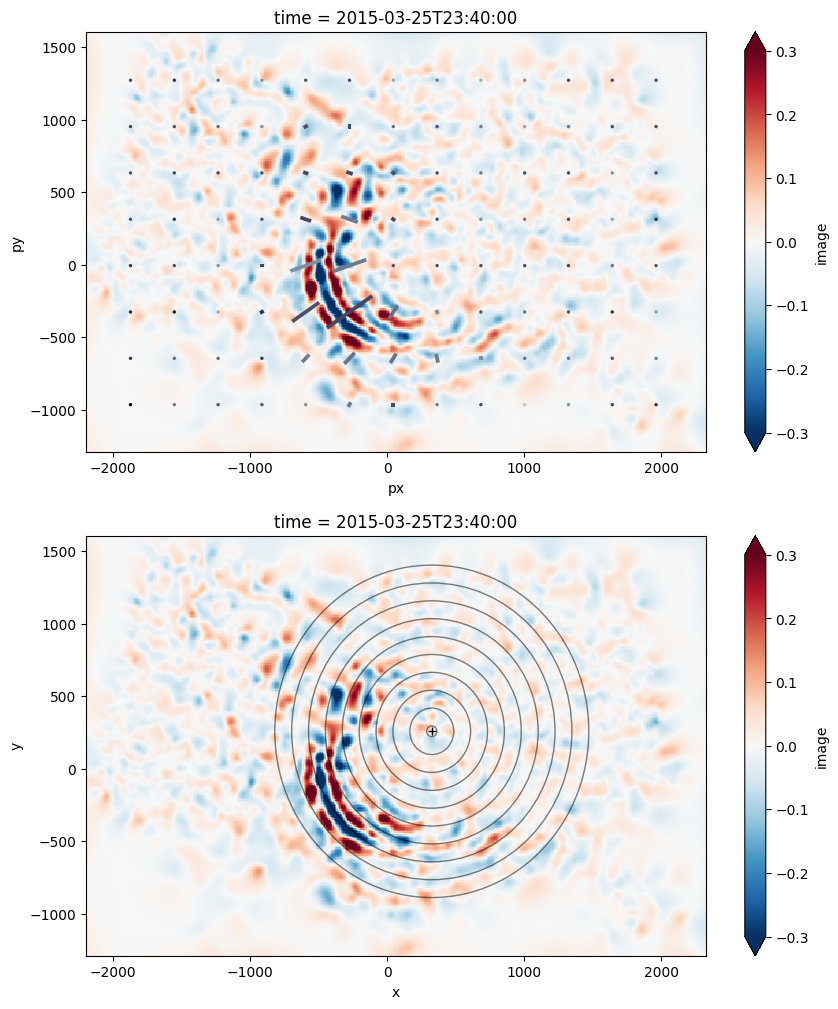

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from gnss_tid.plotting import plot_patches, plot_circles

ii = 100

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
data.height.plot(ax=ax[0, 0])
data.wavelength.plot(ax=ax[0, 1])
data.objective.plot(ax=ax[1, 0], yscale="log")
data.offset.plot(ax=ax[1, 1])
ax[0, 0].axvline(data.time.values[ii], color="k", linestyle='--')
ax[0, 1].axvline(data.time.values[ii], color="k", linestyle='--')
ax[1, 0].axvline(data.time.values[ii], color="k", linestyle='--')
ax[1, 1].axvline(data.time.values[ii], color="k", linestyle='--')

fig, ax = plt.subplots(2, 1, figsize=(10, 12))
plot_patches(data.isel(time=ii), ax=ax[0], scale_base=50)
data.isel(time=ii).image.plot(ax=ax[1], vmax=.3)
center = [data.cx.isel(time=ii), data.cy.isel(time=ii)]
plot_circles(center, data.wavelength.isel(time=ii), data.offset.isel(time=ii), ax=ax[1])

- weight loss by data density
- constant center location
- some constraint on the focus height
    - smooth path height over time